### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import pathlib
import os
import shutil
import random
from tqdm import tqdm
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import splitfolders

import tensorflow as tf
import kerastuner as kt
import numpy as np
import pandas as pd
import pathlib
import os
from os import getcwd
import pandas as pd
from glob import glob
import multiprocessing
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


C:\Users\Kiran A N\anaconda3\envs\gis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Kiran A N\AppData\Local\Temp\ipykernel_22800\2894141654.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
from keras.layers import concatenate

###  Data Loading

In [3]:
dir = "C:\\kiran\\kiran\\Thesis\\coding\\EuroSAT\\"
data_dir = pathlib.Path(dir)

In [4]:
data_dir

WindowsPath('C:/kiran/kiran/Thesis/coding/EuroSAT')

### Image Count

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

27000


- variable initialization

In [6]:
batch_size = 32
img_height = 64
img_width = 64

#### Print Labels

In [7]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 27000 files belonging to 10 classes.


- Classes

In [8]:
labels = os.listdir(dir)
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


### Visualize the data

- define functions

In [9]:
def imgArray(dataset,pathname):
    img_paths = [os.path.join(dataset,pathname+'_1.jpg'),
            os.path.join(dataset,pathname+'_10.jpg'),
            os.path.join(dataset,pathname+'_20.jpg'),
            os.path.join(dataset,pathname+'_30.jpg'),
            os.path.join(dataset,pathname+'_40.jpg')]
    return img_paths

In [10]:
def imgplot(paths):
    plt.figure(figsize=(15, 8))
    for i in range(5):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split("\\")[-1])

- Visualize Highway dataset

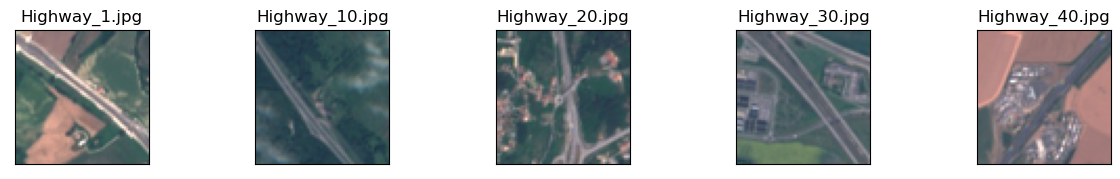

In [11]:
HIGHWAY_DATASET = "C:\\kiran\\kiran\\Thesis\\coding\\EuroSAT\\Highway\\"
img_paths = imgArray(HIGHWAY_DATASET,'Highway')
imgplot(img_paths)

- Visualize AnnualCrop dataset

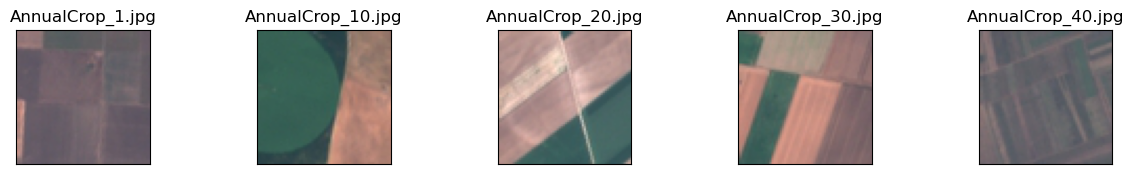

In [12]:
ANNUAL_CROP_DATASET = "C:\\kiran\\kiran\\Thesis\\coding\\EuroSAT\\AnnualCrop\\"
img_paths = imgArray(ANNUAL_CROP_DATASET,'AnnualCrop')
imgplot(img_paths)

### Dataset splitting

- split 0.6 , 0.2, 0.2

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

- assign dataset details

In [14]:
train_ds1, val_ds1, test_ds1 = get_dataset_partitions_tf(ds)

- Autotune and Prefetching

In [15]:
train_ds1 = train_ds1.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds1 = val_ds1.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds1 = test_ds1.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

- Visualize shape and type

In [16]:
train_ds1

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
val_ds1

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
test_ds1

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Data Processing Visualization

#### Flip 

In [19]:
random_flip = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

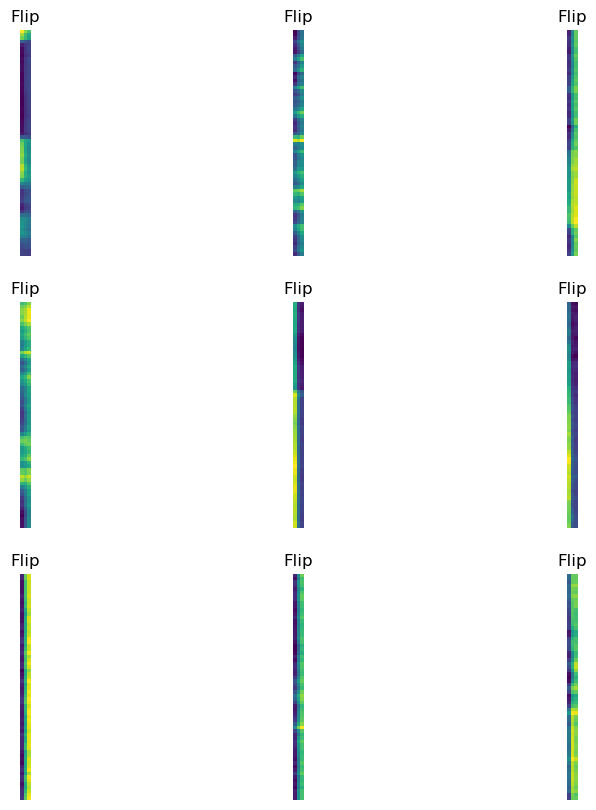

In [20]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_flip(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Flip')
      plt.axis("off")

#### Rotation

In [21]:
random_rotation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.2)
])

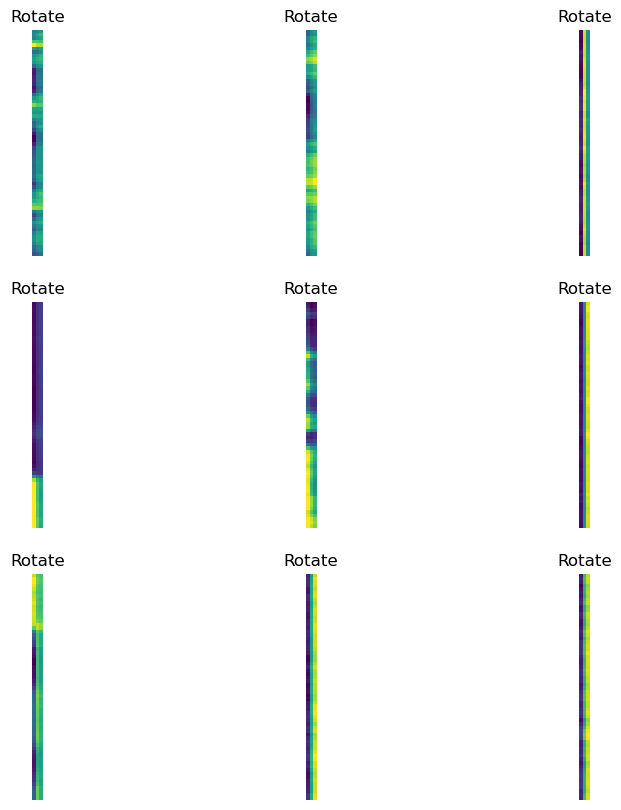

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_rotation(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Rotate')
      plt.axis("off")

#### Contrast

In [23]:
random_contrast = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomContrast(0.2)
])

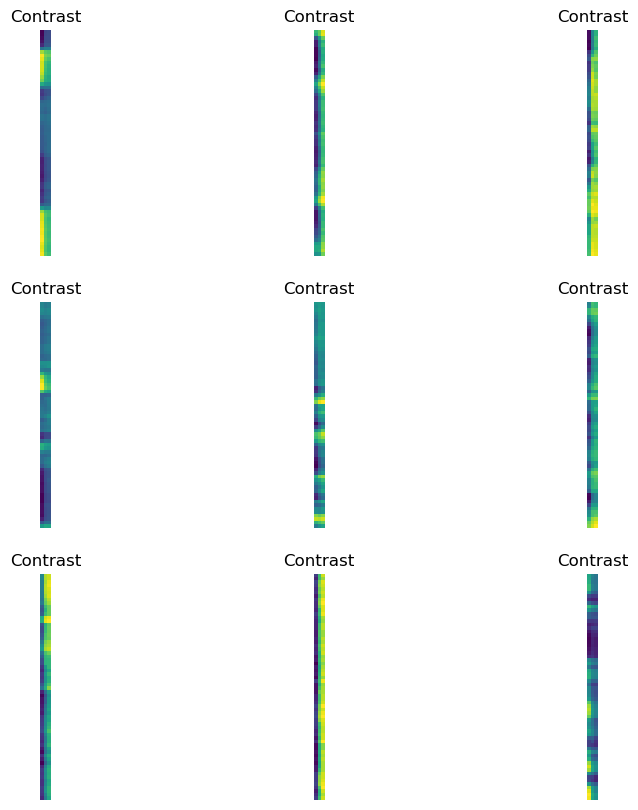

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_contrast(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Contrast')
      plt.axis("off")

#### Zoom

In [25]:
random_zoom = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom(0.2)
])

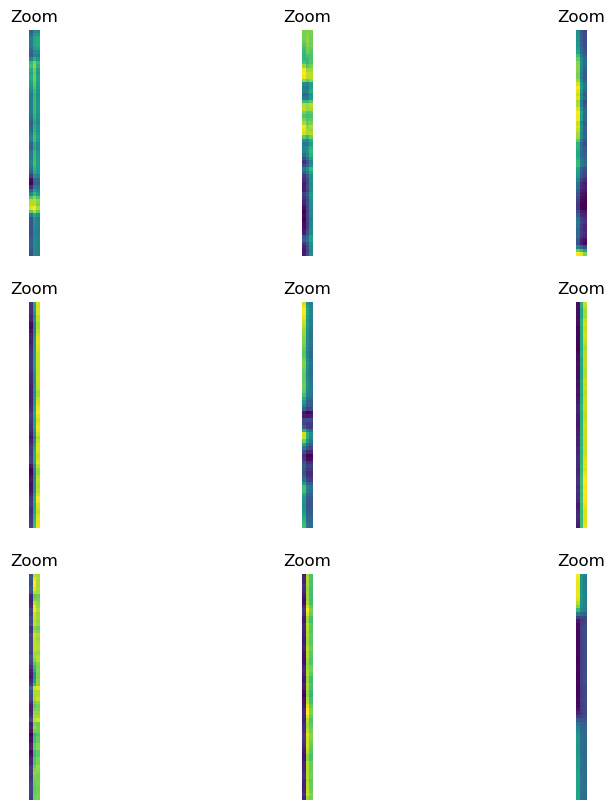

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_zoom(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Zoom')
      plt.axis("off")

In [27]:
random_translation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

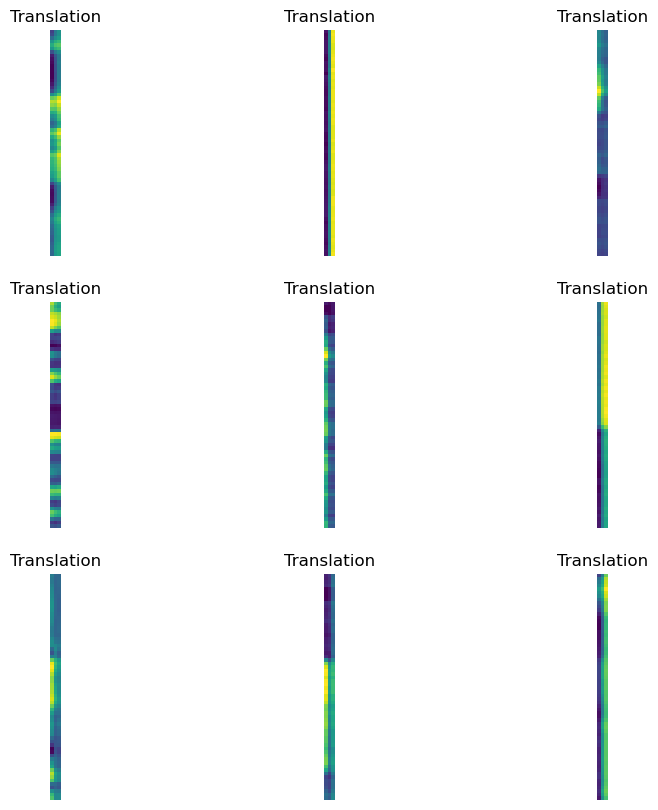

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = random_translation(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Translation')
      plt.axis("off")

#### All augmentation 

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

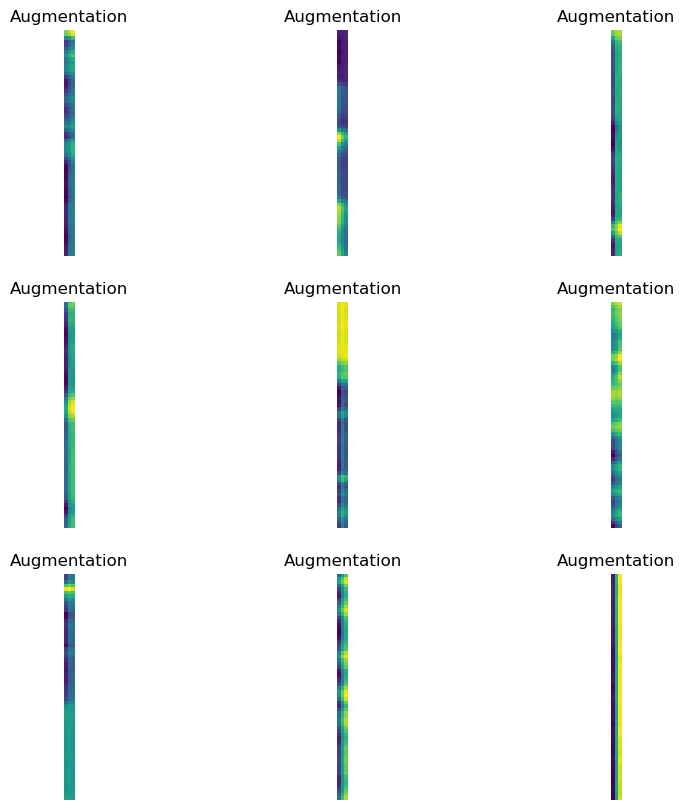

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
  for i in range(9):
      augmented_image = data_augmentation(images[i].numpy().astype("uint8"))
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image[0])
      plt.title('Augmentation')
      plt.axis("off")

#### Resize and Rescale

In [31]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width),
  layers.experimental.preprocessing.Rescaling(1./255),
])

- metrics

In [32]:
from keras import backend as K

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [33]:
metrics = ['accuracy',f1_score,precision_score, recall_score]

### Method 1

- Variable initialization

In [34]:
BATCH_SIZE = 32
IMAGE_SIZE = 64
CHANNELS = 3
EPOCHS = 5

In [35]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

#### Sequential Modeling

In [36]:
CNNmodel1 = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.GaussianNoise(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True, beta_initializer="zeros",gamma_initializer="ones",beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,gamma_constraint=None)
])

#### Build Model

In [37]:
CNNmodel1.build(input_shape=input_shape)

#### Model Summary

In [38]:
CNNmodel1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 64, 64, 3)           0         
                                                                 
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                  

#### Model Compile

In [39]:
CNNmodel1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics
)

In [40]:
CNNModel1_history = CNNmodel1.fit(
    train_ds1,
    batch_size=BATCH_SIZE,
    validation_data=val_ds1,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/5
506/506 [==============================] - 101s 180ms/step - loss: 6.9340 - accuracy: 0.1606 - f1_score: 3.9214 - precision_score: 4.6588 - recall_score: 3.5852 - val_loss: 5.6456 - val_accuracy: 0.1693 - val_f1_score: 4.6721 - val_precision_score: 7.2288 - val_recall_score: 3.6141
Epoch 2/5
506/506 [==============================] - 93s 184ms/step - loss: 5.0638 - accuracy: 0.1725 - f1_score: 4.4448 - precision_score: 4.4476 - recall_score: 4.5878 - val_loss: 3.9737 - val_accuracy: 0.1602 - val_f1_score: 6.4608 - val_precision_score: 9.2810 - val_recall_score: 5.2350
Epoch 3/5
506/506 [==============================] - 83s 165ms/step - loss: 3.9658 - accuracy: 0.1822 - f1_score: 5.1391 - precision_score: 4.8420 - recall_score: 5.6419 - val_loss: 4.2808 - val_accuracy: 0.1685 - val_f1_score: 3.1424 - val_precision_score: 2.2951 - val_recall_score: 5.0028
Epoch 4/5
506/506 [==============================] - 81s 159ms/step - loss: 3.7669 - accuracy: 0.1966 - f1_score: 5.3252 - 

#### Model Scores

In [41]:
scores = CNNmodel1.evaluate(test_ds1)
scores

170/170 [==============================] - 14s 35ms/step - loss: 4.2565 - accuracy: 0.2002 - f1_score: 7.4197 - precision_score: 13.8123 - recall_score: 5.2460


[4.256526947021484,
 0.20018382370471954,
 7.419736385345459,
 13.812307357788086,
 5.2460174560546875]

#### Model Params

In [42]:
CNNModel1_history.params

{'verbose': 1, 'epochs': 5, 'steps': 506}

#### Model History

In [43]:
CNNModel1_history.history["loss"]
CNNModel1_history.history["accuracy"]
acc = CNNModel1_history.history['accuracy']
val_acc = CNNModel1_history.history['val_accuracy']

loss = CNNModel1_history.history['loss']
val_loss = CNNModel1_history.history['val_loss']

#### Training and Validation Accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

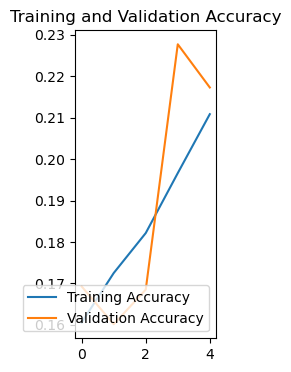

In [44]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#### Training and Validation Loss

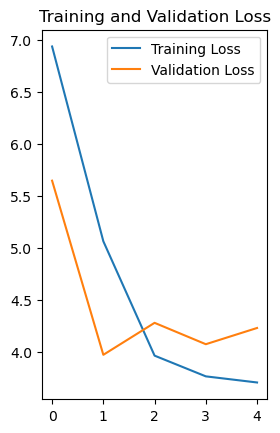

In [45]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Method 2 CNN Model 2

In [46]:
TRAIN_TEST_VAL = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal"

In [47]:
splitfolders.ratio(dir, output=TRAIN_TEST_VAL, seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 27000 files [00:46, 577.72 files/s]


In [48]:
train_dir = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal\\train"
val_dir = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal\\val"
test_dir = "C:\\kiran\\kiran\\Thesis\\coding\\TrainTestVal\\test"

In [49]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 21600 files belonging to 10 classes.


In [50]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 10 classes.


In [51]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 10 classes.


In [52]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
IMG_SIZE = 64

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [55]:
labels

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([7, 6, 3, 8, 2, 4, 6, 7, 9, 4, 9, 1, 0, 7, 4, 3, 0, 8, 4, 6, 4, 0,
       5, 3, 8, 8, 5, 8, 0, 6, 9, 7])>

In [56]:
num_classes = len(labels)
CNNModel2 = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [57]:
CNNModel2.build(input_shape=input_shape)

In [58]:
CNNModel2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (32, 64, 64, 16)          448       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 32, 32, 16)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 32, 32, 32)          4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 16, 16, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 16, 16, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 8, 8, 64)          

In [59]:
CNNModel2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=metrics)

In [60]:
epochs=2
CNNModel2_history = CNNModel2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/2
675/675 [==============================] - 53s 69ms/step - loss: 1.5778 - accuracy: 0.5728 - f1_score: 1.6766 - precision_score: 0.9275 - recall_score: 8.8733 - val_loss: 0.8969 - val_accuracy: 0.6707 - val_f1_score: 1.6515 - val_precision_score: 0.9206 - val_recall_score: 8.0424
Epoch 2/2
675/675 [==============================] - 52s 77ms/step - loss: 0.8210 - accuracy: 0.7083 - f1_score: 1.6457 - precision_score: 0.9185 - recall_score: 7.9354 - val_loss: 0.7903 - val_accuracy: 0.7200 - val_f1_score: 1.6445 - val_precision_score: 0.9155 - val_recall_score: 8.1004


In [61]:
CNNModel2.evaluate(test_ds)

85/85 [==============================] - 3s 35ms/step - loss: 0.7659 - accuracy: 0.7163 - f1_score: 1.6455 - precision_score: 0.9160 - recall_score: 8.1050


[0.7658824324607849,
 0.7162963151931763,
 1.645481824874878,
 0.9160377979278564,
 8.105034828186035]

In [62]:
CNNModel2_history.history["loss"]
CNNModel2_history.history["accuracy"]
acc = CNNModel2_history.history['accuracy']
val_acc = CNNModel2_history.history['val_accuracy']

loss = CNNModel2_history.history['loss']
val_loss = CNNModel2_history.history['val_loss']

### Method 3

In [63]:
epochs =2 

In [64]:
def create_resnet_model():
    input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
    x= data_augmentation(input_layer)
    base_model = tf.keras.applications.ResNet50V2(
                    include_top=False,
                    weights='imagenet',
                    input_tensor=x
                )
    
    base_model.trainable = False
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=metrics)
    return model
resnetmodel= create_resnet_model()

In [65]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  

In [66]:
resnetmodel.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 8193      
                                                                 
Total params: 23,572,993
Trainable params: 8,193
Non-trainable params: 23,564,800
_________________________________________________________________


In [67]:
resnet_history = resnetmodel.fit(train_ds,
          steps_per_epoch=100,
          validation_data=   val_ds,
          validation_steps=100,
                           callbacks=[earlyStopCallback],
         
          epochs=epochs)

Epoch 1/2
100/100 [==============================] - 58s 427ms/step - loss: 0.0000e+00 - accuracy: 0.1094 - f1_score: 0.9384 - precision_score: 0.8853 - recall_score: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.1111 - val_f1_score: 0.9404 - val_precision_score: 0.8891 - val_recall_score: 1.0000
Epoch 2/2
100/100 [==============================] - 22s 218ms/step - loss: 0.0000e+00 - accuracy: 0.1053 - f1_score: 0.9359 - precision_score: 0.8809 - recall_score: 1.0000


In [68]:
resnetmodel.evaluate(test_ds)

85/85 [==============================] - 18s 211ms/step - loss: 0.0000e+00 - accuracy: 0.1111 - f1_score: 0.9403 - precision_score: 0.8891 - recall_score: 1.0000


[0.0, 0.1111111119389534, 0.9403372406959534, 0.8890931010246277, 1.0]

In [69]:
resnet_history.history["loss"]
resnet_history.history["accuracy"]
acc = resnet_history.history['accuracy']
val_acc = resnet_history.history['val_accuracy']

loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

### Method 4 Hybrid Modeling or Multi Filter Modeling

#### Hyper Parameter Tuning

In [70]:
def create_multifilter_model(conv2dFilters, data_augmentation, num_filters):
    conv2DLayer = layers.Conv2D(conv2dFilters, 3, padding='same', activation='relu')
    sequential_input = [data_augmentation]
    
    for i in range(num_filters):
        sequential_input.append(conv2DLayer)
        sequential_input.append(layers.MaxPooling2D())
    sequential_input.append(layers.Flatten())
    sequential_input.append(layers.GaussianNoise(0.1))
    sequential_input.append(layers.Dense(64, activation='relu'))
    sequential_input.append(layers.Dense(n_classes, activation='softmax'))
    sequential_input.append(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True, beta_initializer="zeros",gamma_initializer="ones",beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,gamma_constraint=None))
    CNNModel = tf.keras.Sequential(sequential_input)
    CNNModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=metrics)
    return CNNModel

In [71]:
FilterCNNModel1 = create_multifilter_model(32,data_augmentation, 2)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel1.build(input_shape=input_shape)
FilterCNNModel1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_9 (Conv2D)           (32, 64, 64, 32)          896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 32, 32, 32)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 16, 16, 32)         0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (32, 8192)                0         
                                                                 
 gaussian_noise_1 (GaussianN  (32, 8192)             

In [72]:
FilterCNNModel1_history =FilterCNNModel1.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=5)

Epoch 1/5
506/506 [==============================] - 64s 107ms/step - loss: 2.7373 - accuracy: 0.0947 - f1_score: 1.0993 - precision_score: 1.0401 - recall_score: 1.1683 - val_loss: 2.4265 - val_accuracy: 0.0969 - val_f1_score: 2.9034 - val_precision_score: 2.7483 - val_recall_score: 3.0828
Epoch 2/5
506/506 [==============================] - 53s 105ms/step - loss: 2.3531 - accuracy: 0.0947 - f1_score: 5.2367 - precision_score: 4.9558 - recall_score: 5.5639 - val_loss: 2.3104 - val_accuracy: 0.0969 - val_f1_score: 6.7258 - val_precision_score: 6.3640 - val_recall_score: 7.1451
Epoch 3/5
506/506 [==============================] - 51s 102ms/step - loss: 2.3031 - accuracy: 0.0947 - f1_score: 10.2384 - precision_score: 913557248.0000 - recall_score: 7.2335 - val_loss: 2.2959 - val_accuracy: 0.0969 - val_f1_score: 14.5084 - val_precision_score: 2067678336.0000 - val_recall_score: 7.2542
Epoch 4/5
506/506 [==============================] - 51s 101ms/step - loss: 2.2965 - accuracy: 0.1093 - f

In [73]:
FilterCNNModel2 = create_multifilter_model(64,data_augmentation, 3)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel2.build(input_shape=input_shape)
FilterCNNModel2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_10 (Conv2D)          (32, 64, 64, 64)          1792      
                                                                 
 max_pooling2d_14 (MaxPoolin  (32, 32, 32, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_15 (MaxPoolin  (32, 16, 16, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_16 (MaxPoolin  (32, 8, 8, 64)           0         
 g2D)                                                            
                                                     

In [74]:
FilterCNNModel2_history =FilterCNNModel2.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=3)

Epoch 1/3
506/506 [==============================] - 72s 120ms/step - loss: 2.7433 - accuracy: 0.0921 - f1_score: 1.0500 - precision_score: 0.9943 - recall_score: 1.1150 - val_loss: 2.4395 - val_accuracy: 0.0880 - val_f1_score: 2.3844 - val_precision_score: 2.2571 - val_recall_score: 2.5318
Epoch 2/3
506/506 [==============================] - 60s 119ms/step - loss: 2.3559 - accuracy: 0.0921 - f1_score: 5.1783 - precision_score: 4.9018 - recall_score: 5.5005 - val_loss: 2.3155 - val_accuracy: 0.0880 - val_f1_score: 6.5121 - val_precision_score: 6.1618 - val_recall_score: 6.9179
Epoch 3/3
506/506 [==============================] - 59s 116ms/step - loss: 2.3041 - accuracy: 0.0921 - f1_score: 10.6056 - precision_score: 1028142144.0000 - recall_score: 7.2038 - val_loss: 2.2974 - val_accuracy: 0.0880 - val_f1_score: 14.7162 - val_precision_score: 2097202304.0000 - val_recall_score: 7.3581


In [75]:
FilterCNNModel3 = create_multifilter_model(64,data_augmentation, 4)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel3.build(input_shape=input_shape)
FilterCNNModel3.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_11 (Conv2D)          (32, 64, 64, 64)          1792      
                                                                 
 max_pooling2d_17 (MaxPoolin  (32, 32, 32, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 16, 16, 64)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 8, 8, 64)           0         
 g2D)                                                            
                                                     

In [76]:
FilterCNNModel3_history =FilterCNNModel3.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=3)

Epoch 1/3
506/506 [==============================] - 70s 121ms/step - loss: 2.7004 - accuracy: 0.1118 - f1_score: 1.0615 - precision_score: 1.0048 - recall_score: 1.1275 - val_loss: 2.4083 - val_accuracy: 0.1129 - val_f1_score: 2.5640 - val_precision_score: 2.4269 - val_recall_score: 2.7228
Epoch 2/3
506/506 [==============================] - 61s 121ms/step - loss: 2.3413 - accuracy: 0.1120 - f1_score: 4.8860 - precision_score: 4.6251 - recall_score: 5.1902 - val_loss: 2.3058 - val_accuracy: 0.1129 - val_f1_score: 6.5111 - val_precision_score: 6.1607 - val_recall_score: 6.9171
Epoch 3/3
506/506 [==============================] - 59s 116ms/step - loss: 2.3003 - accuracy: 0.1120 - f1_score: 7.2327 - precision_score: 162766800.0000 - recall_score: 7.0490 - val_loss: 2.2951 - val_accuracy: 0.1129 - val_f1_score: 14.2602 - val_precision_score: 2032142592.0000 - val_recall_score: 7.1301


In [77]:
FilterCNNModel3.evaluate(test_ds1)

170/170 [==============================] - 6s 34ms/step - loss: 2.2975 - accuracy: 0.1066 - f1_score: 14.0409 - precision_score: 1997293824.0000 - recall_score: 7.0204


[2.2975423336029053,
 0.10661764442920685,
 14.040879249572754,
 1997293824.0,
 7.020439624786377]

### Test with Weights

In [104]:
from tensorflow.keras import initializers

In [110]:
def create_multifilter_model_w(conv2dFilters, data_augmentation, num_filters):
    conv2DLayer = layers.Conv2D(conv2dFilters, 3, padding='same', activation='relu')
    sequential_input = [data_augmentation]
    
    for i in range(num_filters):
        sequential_input.append(conv2DLayer)
        sequential_input.append(layers.MaxPooling2D((2,2), padding='same'))
    sequential_input.append(layers.Flatten())
    sequential_input.append(layers.GaussianNoise(0.1))
    sequential_input.append(layers.Dense(64, activation='relu'))
    sequential_input.append(layers.Dense(n_classes, activation='softmax'))
    sequential_input.append(layers.Dense(
        units=64,
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.Zeros()
    ))
    sequential_input.append(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True, beta_initializer="zeros",gamma_initializer="ones",beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,gamma_constraint=None))
    CNNModel = tf.keras.Sequential(sequential_input)
    CNNModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=metrics)
    return CNNModel

In [114]:
FilterCNNModel4 = create_multifilter_model_w(128,data_augmentation, 20)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel4.build(input_shape=input_shape)
FilterCNNModel4.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_21 (Conv2D)          (32, 64, 64, 128)         3584      
                                                                 
 max_pooling2d_69 (MaxPoolin  (32, 32, 32, 128)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_70 (MaxPoolin  (32, 16, 16, 128)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_71 (MaxPoolin  (32, 8, 8, 128)          0         
 g2D)                                                            
                                                     

In [115]:
FilterCNNModel4.weights

[<tf.Variable 'conv2d_21/kernel:0' shape=(3, 3, 3, 128) dtype=float32, numpy=
 array([[[[-4.26212028e-02, -9.53848287e-03, -6.22794181e-02, ...,
            3.12032104e-02, -6.61102980e-02, -9.56441835e-03],
          [ 1.81007907e-02,  3.67211327e-02,  6.22898340e-02, ...,
            2.25962028e-02, -6.42970353e-02, -5.94334006e-02],
          [-1.52276643e-02,  5.84897548e-02, -3.41903120e-02, ...,
           -2.07097009e-02, -4.11244258e-02, -1.78368427e-02]],
 
         [[-3.95923853e-05, -1.89597420e-02,  6.96733743e-02, ...,
            1.60961524e-02,  8.05075467e-03, -6.90745935e-02],
          [-9.70380008e-03,  3.64257023e-02, -5.81578165e-02, ...,
            4.84752059e-02,  5.41851074e-02,  1.81368142e-02],
          [-4.07181159e-02, -5.09317070e-02, -3.92557681e-02, ...,
            4.54606116e-03, -6.45372942e-02, -2.32738443e-02]],
 
         [[-2.46231556e-02, -5.49954474e-02,  2.78456658e-02, ...,
            2.38530710e-02,  4.41467911e-02, -1.79170854e-02],
      

In [120]:
FilterCNNModel4_history =FilterCNNModel4.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=2)

Epoch 1/2
506/506 [==============================] - 79s 155ms/step - loss: 2.3019 - accuracy: 0.1107 - f1_score: 1.6350 - precision_score: 0.8906 - recall_score: 10.0000 - val_loss: 2.2988 - val_accuracy: 0.1205 - val_f1_score: 1.6348 - val_precision_score: 0.8904 - val_recall_score: 10.0000
Epoch 2/2
506/506 [==============================] - 81s 161ms/step - loss: 2.3006 - accuracy: 0.1107 - f1_score: 1.6349 - precision_score: 0.8906 - recall_score: 10.0000 - val_loss: 2.2998 - val_accuracy: 0.1096 - val_f1_score: 1.6348 - val_precision_score: 0.8904 - val_recall_score: 10.0000


In [121]:
data_augmentation_1 = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

In [122]:
FilterCNNModel5 = create_multifilter_model_w(128,data_augmentation_1, 20)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel5.build(input_shape=input_shape)
FilterCNNModel5.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (32, 64, 64, 3)           0         
                                                                 
 conv2d_22 (Conv2D)          (32, 64, 64, 128)         3584      
                                                                 
 max_pooling2d_89 (MaxPoolin  (32, 32, 32, 128)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_90 (MaxPoolin  (32, 16, 16, 128)        0         
 g2D)                                                            
                                                                 
 max_pooling2d_91 (MaxPoolin  (32, 8, 8, 128)          0         
 g2D)                                                            
                                                     

In [123]:
FilterCNNModel5_history =FilterCNNModel5.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=2)

Epoch 1/2
506/506 [==============================] - 85s 140ms/step - loss: 2.5668 - accuracy: 0.1101 - f1_score: 1.7728 - precision_score: 0.9908 - recall_score: 10.3102 - val_loss: 2.4236 - val_accuracy: 0.1205 - val_f1_score: 1.6348 - val_precision_score: 0.8904 - val_recall_score: 10.0000
Epoch 2/2
506/506 [==============================] - 74s 146ms/step - loss: 2.3910 - accuracy: 0.1139 - f1_score: 1.6349 - precision_score: 0.8906 - recall_score: 10.0000 - val_loss: 2.3653 - val_accuracy: 0.1129 - val_f1_score: 1.6348 - val_precision_score: 0.8904 - val_recall_score: 10.0000


In [546]:
FilterCNNModel5.evaluate(test_ds1)

170/170 [==============================] - 7s 40ms/step - loss: 2.3683 - accuracy: 0.1066 - f1_score: 1.6327 - precision_score: 0.8892 - recall_score: 10.0000


[2.3682734966278076,
 0.10661764442920685,
 1.6326619386672974,
 0.8891544342041016,
 10.0]

In [143]:
def create_multifilter_model_w2(conv2dFilters, data_augmentation, num_filters):
    sequential_input = [data_augmentation]
    layerMul = 16
    for i in range(num_filters):
        conv2DLayer = layers.Conv2D(layerMul*(i+1), 3, padding='same', activation='relu')
        sequential_input.append(conv2DLayer)
        sequential_input.append(layers.MaxPooling2D((2,2), padding='same'))
    sequential_input.append(layers.Flatten())
    sequential_input.append(layers.GaussianNoise(0.1))
    sequential_input.append(layers.Dense(64, activation='relu'))
    sequential_input.append(layers.Dense(n_classes, activation='softmax'))
    
    CNNModel = tf.keras.Sequential(sequential_input)
    CNNModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=metrics)
    return CNNModel

In [147]:
FilterCNNModel6 = create_multifilter_model_w2(128,random_flip, 5)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel6.build(input_shape=input_shape)
FilterCNNModel6.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 64, 3)               0         
                                                                 
 conv2d_48 (Conv2D)          (32, 64, 64, 16)          448       
                                                                 
 max_pooling2d_174 (MaxPooli  (32, 32, 32, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (32, 32, 32, 32)          4640      
                                                                 
 max_pooling2d_175 (MaxPooli  (32, 16, 16, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (32, 16, 16, 48)        

In [148]:
FilterCNNModel6_history =FilterCNNModel6.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=2)

Epoch 1/2
506/506 [==============================] - 32s 61ms/step - loss: 1.3568 - accuracy: 0.5261 - f1_score: 3.2343 - precision_score: 25197626.0000 - recall_score: 2.3658 - val_loss: 1.4362 - val_accuracy: 0.5063 - val_f1_score: 2.3841 - val_precision_score: 2.7785 - val_recall_score: 2.1102
Epoch 2/2
506/506 [==============================] - 36s 72ms/step - loss: 0.9289 - accuracy: 0.6632 - f1_score: 2.1753 - precision_score: 2.5149 - recall_score: 1.9424 - val_loss: 0.8246 - val_accuracy: 0.6962 - val_f1_score: 2.0146 - val_precision_score: 2.2087 - val_recall_score: 1.8659


In [149]:
FilterCNNModel6.evaluate(test_ds1)

170/170 [==============================] - 5s 30ms/step - loss: 0.8276 - accuracy: 0.6958 - f1_score: 2.0444 - precision_score: 2.2455 - recall_score: 1.8901


[0.8276475071907043,
 0.6957720518112183,
 2.044405221939087,
 2.245534896850586,
 1.8901264667510986]

In [150]:
FilterCNNModel7 = create_multifilter_model_w2(128,random_contrast, 5)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel7.build(input_shape=input_shape)
FilterCNNModel7.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_53 (Conv2D)          (32, 64, 64, 16)          448       
                                                                 
 max_pooling2d_179 (MaxPooli  (32, 32, 32, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (32, 32, 32, 32)          4640      
                                                                 
 max_pooling2d_180 (MaxPooli  (32, 16, 16, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (32, 16, 16, 48)        

In [151]:
FilterCNNModel7_history =FilterCNNModel7.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=2)

Epoch 1/2
506/506 [==============================] - 38s 70ms/step - loss: 1.2610 - accuracy: 0.5468 - f1_score: 3.0428 - precision_score: 6106720.0000 - recall_score: 2.3126 - val_loss: 0.8892 - val_accuracy: 0.6847 - val_f1_score: 2.2820 - val_precision_score: 2.7099 - val_recall_score: 1.9857
Epoch 2/2
506/506 [==============================] - 41s 80ms/step - loss: 0.9159 - accuracy: 0.6744 - f1_score: 2.1436 - precision_score: 2.4484 - recall_score: 1.9261 - val_loss: 0.8533 - val_accuracy: 0.6931 - val_f1_score: 1.7629 - val_precision_score: 1.8615 - val_recall_score: 1.6837


In [152]:
FilterCNNModel7.evaluate(test_ds1)

170/170 [==============================] - 3s 19ms/step - loss: 0.8678 - accuracy: 0.6873 - f1_score: 1.7408 - precision_score: 1.8289 - recall_score: 1.6685


[0.8677743077278137,
 0.6873161792755127,
 1.7407571077346802,
 1.82891845703125,
 1.6685017347335815]

In [153]:
FilterCNNModel8 = create_multifilter_model_w2(128,random_translation, 5)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel8.build(input_shape=input_shape)
FilterCNNModel8.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_58 (Conv2D)          (32, 64, 64, 16)          448       
                                                                 
 max_pooling2d_184 (MaxPooli  (32, 32, 32, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (32, 32, 32, 32)          4640      
                                                                 
 max_pooling2d_185 (MaxPooli  (32, 16, 16, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_60 (Conv2D)          (32, 16, 16, 48)        

In [154]:
FilterCNNModel8_history =FilterCNNModel8.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=2)

Epoch 1/2
506/506 [==============================] - 39s 71ms/step - loss: 1.5712 - accuracy: 0.4716 - f1_score: 3.9237 - precision_score: 45691700.0000 - recall_score: 2.6580 - val_loss: 0.9648 - val_accuracy: 0.6648 - val_f1_score: 2.3271 - val_precision_score: 2.7268 - val_recall_score: 2.0494
Epoch 2/2
506/506 [==============================] - 42s 82ms/step - loss: 1.0130 - accuracy: 0.6348 - f1_score: 2.4143 - precision_score: 2.9117 - recall_score: 2.0877 - val_loss: 0.7670 - val_accuracy: 0.7152 - val_f1_score: 2.0240 - val_precision_score: 2.2343 - val_recall_score: 1.8627


In [155]:
FilterCNNModel8.evaluate(test_ds1)

170/170 [==============================] - 4s 22ms/step - loss: 0.7849 - accuracy: 0.7151 - f1_score: 2.0449 - precision_score: 2.2613 - recall_score: 1.8774


[0.7849032282829285,
 0.7150735259056091,
 2.044883966445923,
 2.2613446712493896,
 1.8774230480194092]

In [157]:
FilterCNNModel9 = create_multifilter_model_w2(128,random_rotation, 5)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel9.build(input_shape=input_shape)
FilterCNNModel9.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_68 (Conv2D)          (32, 64, 64, 16)          448       
                                                                 
 max_pooling2d_194 (MaxPooli  (32, 32, 32, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_69 (Conv2D)          (32, 32, 32, 32)          4640      
                                                                 
 max_pooling2d_195 (MaxPooli  (32, 16, 16, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_70 (Conv2D)          (32, 16, 16, 48)        

In [158]:
FilterCNNModel9_history =FilterCNNModel9.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=2)

Epoch 1/2
506/506 [==============================] - 39s 70ms/step - loss: 1.4928 - accuracy: 0.4633 - f1_score: 3.9870 - precision_score: 66462448.0000 - recall_score: 2.6786 - val_loss: 0.9972 - val_accuracy: 0.6432 - val_f1_score: 2.5753 - val_precision_score: 3.3108 - val_recall_score: 2.1307
Epoch 2/2
506/506 [==============================] - 41s 81ms/step - loss: 1.0205 - accuracy: 0.6257 - f1_score: 2.4207 - precision_score: 2.9534 - recall_score: 2.0813 - val_loss: 0.9619 - val_accuracy: 0.6618 - val_f1_score: 2.2540 - val_precision_score: 2.7122 - val_recall_score: 1.9488


In [159]:
FilterCNNModel9.evaluate(test_ds1)

170/170 [==============================] - 3s 19ms/step - loss: 0.9904 - accuracy: 0.6526 - f1_score: 2.2814 - precision_score: 2.7666 - recall_score: 1.9607


[0.9904400110244751,
 0.6525735259056091,
 2.281379222869873,
 2.766556739807129,
 1.960688829421997]

In [160]:
FilterCNNModel10 = create_multifilter_model_w2(128,random_zoom, 5)
batch_size=32
image_size=64
channels=3
input_shape = (batch_size, image_size, image_size, channels)
FilterCNNModel10.build(input_shape=input_shape)
FilterCNNModel10.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_73 (Conv2D)          (32, 64, 64, 16)          448       
                                                                 
 max_pooling2d_199 (MaxPooli  (32, 32, 32, 16)         0         
 ng2D)                                                           
                                                                 
 conv2d_74 (Conv2D)          (32, 32, 32, 32)          4640      
                                                                 
 max_pooling2d_200 (MaxPooli  (32, 16, 16, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_75 (Conv2D)          (32, 16, 16, 48)        

In [161]:
FilterCNNModel10_history =FilterCNNModel10.fit(train_ds1,
    batch_size=batch_size,
    validation_data=val_ds1,
    verbose=1,
    epochs=2)

Epoch 1/2
506/506 [==============================] - 39s 71ms/step - loss: 1.5866 - accuracy: 0.4655 - f1_score: 3.8890 - precision_score: 72509880.0000 - recall_score: 2.6064 - val_loss: 1.1604 - val_accuracy: 0.5891 - val_f1_score: 3.2849 - val_precision_score: 5.4549 - val_recall_score: 2.3930
Epoch 2/2
506/506 [==============================] - 39s 78ms/step - loss: 1.0375 - accuracy: 0.6277 - f1_score: 2.4313 - precision_score: 3.0207 - recall_score: 2.0723 - val_loss: 0.9545 - val_accuracy: 0.6483 - val_f1_score: 2.1760 - val_precision_score: 2.5586 - val_recall_score: 1.9131


In [162]:
FilterCNNModel10.evaluate(test_ds1)

170/170 [==============================] - 3s 19ms/step - loss: 0.9753 - accuracy: 0.6382 - f1_score: 2.1534 - precision_score: 2.5204 - recall_score: 1.8942


[0.97529536485672,
 0.6382352709770203,
 2.1534056663513184,
 2.5204379558563232,
 1.894243836402893]

### Accuracy Graph

### flip

In [166]:
FilterCNNModel10_history.history

{'loss': [1.5865592956542969, 1.0374771356582642],
 'accuracy': [0.46552151441574097, 0.6277187466621399],
 'f1_score': [3.8890128135681152, 2.4313199520111084],
 'precision_score': [72509880.0, 3.020673990249634],
 'recall_score': [2.606431722640991, 2.072330951690674],
 'val_loss': [1.1604375839233398, 0.9545303583145142],
 'val_accuracy': [0.5890997052192688, 0.648251473903656],
 'val_f1_score': [3.2849252223968506, 2.176046371459961],
 'val_precision_score': [5.454868793487549, 2.5586459636688232],
 'val_recall_score': [2.3929948806762695, 1.9130502939224243]}

In [167]:
FilterCNNModel10_history.history['accuracy']

[0.46552151441574097, 0.6277187466621399]

Text(0.5, 1.0, 'Training and Validation Accuracy')

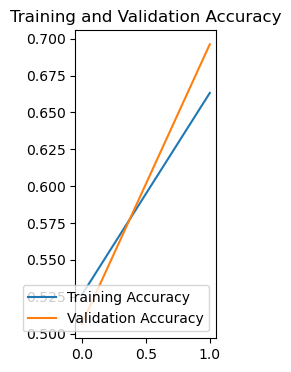

In [169]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2), FilterCNNModel6_history.history['accuracy'], label='Training Accuracy')
plt.plot(range(2), FilterCNNModel6_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### contrast

Text(0.5, 1.0, 'Training and Validation Accuracy')

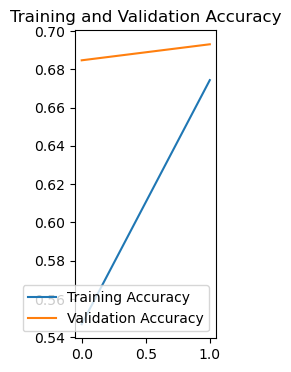

In [170]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2), FilterCNNModel7_history.history['accuracy'], label='Training Accuracy')
plt.plot(range(2), FilterCNNModel7_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### translation

Text(0.5, 1.0, 'Training and Validation Accuracy')

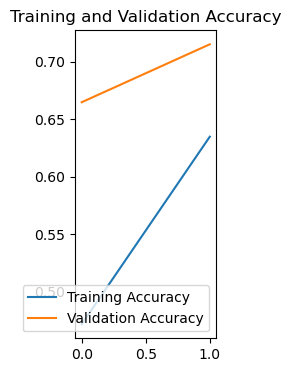

In [171]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2), FilterCNNModel8_history.history['accuracy'], label='Training Accuracy')
plt.plot(range(2), FilterCNNModel8_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### rotation

Text(0.5, 1.0, 'Training and Validation Accuracy')

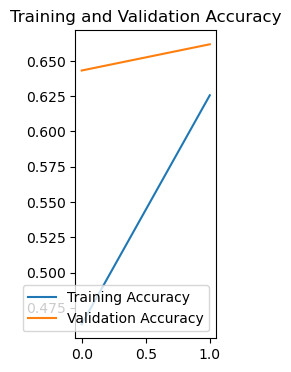

In [172]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2), FilterCNNModel9_history.history['accuracy'], label='Training Accuracy')
plt.plot(range(2), FilterCNNModel9_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### zoom

Text(0.5, 1.0, 'Training and Validation Accuracy')

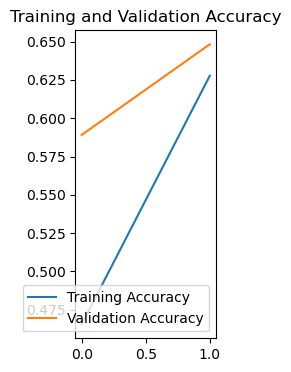

In [173]:
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2), FilterCNNModel10_history.history['accuracy'], label='Training Accuracy')
plt.plot(range(2), FilterCNNModel10_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

### Plot all test accuracies

Text(0.5, 0, 'max depth')

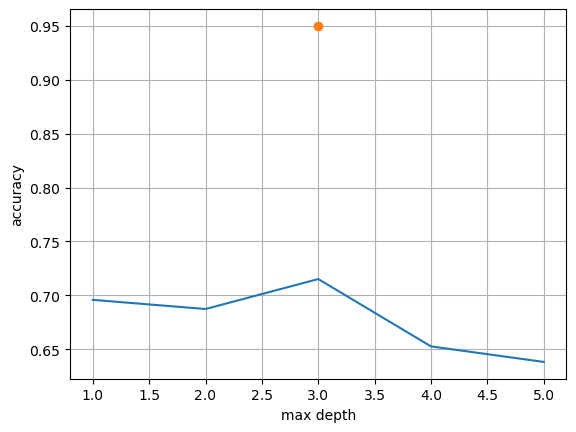

In [175]:
import matplotlib.pyplot as plt
flip_test_accuracy = 0.6958
contrast_test_accuracy = 0.6873
translation_test_accuracy = 0.7151
rotation_test_accuracy = 0.6526
zoom_test_accuracy = 0.6382
accuracy = [flip_test_accuracy, contrast_test_accuracy,translation_test_accuracy,rotation_test_accuracy, zoom_test_accuracy]
max_depth = list(range(1, 6))

plt.plot(max_depth, accuracy) #adds the line
plt.plot(3, 0.95, marker='o') #adds the point
plt.grid() #adds a grid to the plot
plt.ylabel('accuracy') #xlabel
plt.xlabel('max depth') #ylabel

In [185]:
CNNmodel_exp = Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu',padding='same', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same' ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.GaussianNoise(0.1),
    layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True, beta_initializer="zeros",gamma_initializer="ones",beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,gamma_constraint=None),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [186]:
CNNmodel_exp.build(input_shape=input_shape)

In [222]:
CNNmodel_exp.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 sequential_5 (Sequential)   (64, 64, 3)               0         
                                                                 
 conv2d_90 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_216 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_91 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_217 (MaxPooli  (None, 16, 16, 64)       0         
 ng2D)                                               

In [187]:
CNNmodel_exp.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=metrics
)

In [188]:
CNNModel_exp_history = CNNmodel_exp.fit(
    train_ds1,
    batch_size=BATCH_SIZE,
    validation_data=val_ds1,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/5
506/506 [==============================] - 79s 136ms/step - loss: 2.0297 - accuracy: 0.2260 - f1_score: 7.3549 - precision_score: 79268760.0000 - recall_score: 4.0805 - val_loss: 1.9577 - val_accuracy: 0.2359 - val_f1_score: 6.8225 - val_precision_score: 8095249.0000 - val_recall_score: 3.9427
Epoch 2/5
506/506 [==============================] - 74s 145ms/step - loss: 1.9427 - accuracy: 0.2563 - f1_score: 7.1831 - precision_score: 24347832.0000 - recall_score: 4.0738 - val_loss: 1.8943 - val_accuracy: 0.2759 - val_f1_score: 7.1789 - val_precision_score: 14880968.0000 - val_recall_score: 4.0754
Epoch 3/5
506/506 [==============================] - 73s 145ms/step - loss: 1.9282 - accuracy: 0.2579 - f1_score: 7.1881 - precision_score: 16956540.0000 - recall_score: 4.0783 - val_loss: 1.9142 - val_accuracy: 0.2576 - val_f1_score: 7.1892 - val_precision_score: 15595258.0000 - val_recall_score: 4.1523
Epoch 4/5
506/506 [==============================] - 67s 133ms/step - loss: 1.9219 

### Feature Extraction

In [253]:
labels = os.listdir(dir)
print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [455]:
layer_names3 = [layer.name for layer in FilterCNNModel10.layers]
layer_names3

['sequential_3',
 'conv2d_73',
 'max_pooling2d_199',
 'conv2d_74',
 'max_pooling2d_200',
 'conv2d_75',
 'max_pooling2d_201',
 'conv2d_76',
 'max_pooling2d_202',
 'conv2d_77',
 'max_pooling2d_203',
 'flatten_29',
 'gaussian_noise_27',
 'dense_66',
 'dense_67']

In [482]:
layer_names3.pop(0)

'sequential_3'

In [468]:
layer_outputs3 = [layer.output for layer in FilterCNNModel10.layers]
layer_outputs3

[<KerasTensor: shape=(64, 64, 3) dtype=float32 (created by layer 'random_zoom')>,
 <KerasTensor: shape=(None, 64, 64, 16) dtype=float32 (created by layer 'conv2d_73')>,
 <KerasTensor: shape=(None, 32, 32, 16) dtype=float32 (created by layer 'max_pooling2d_199')>,
 <KerasTensor: shape=(None, 32, 32, 32) dtype=float32 (created by layer 'conv2d_74')>,
 <KerasTensor: shape=(None, 16, 16, 32) dtype=float32 (created by layer 'max_pooling2d_200')>,
 <KerasTensor: shape=(None, 16, 16, 48) dtype=float32 (created by layer 'conv2d_75')>,
 <KerasTensor: shape=(None, 8, 8, 48) dtype=float32 (created by layer 'max_pooling2d_201')>,
 <KerasTensor: shape=(None, 8, 8, 64) dtype=float32 (created by layer 'conv2d_76')>,
 <KerasTensor: shape=(None, 4, 4, 64) dtype=float32 (created by layer 'max_pooling2d_202')>,
 <KerasTensor: shape=(None, 4, 4, 80) dtype=float32 (created by layer 'conv2d_77')>,
 <KerasTensor: shape=(None, 2, 2, 80) dtype=float32 (created by layer 'max_pooling2d_203')>,
 <KerasTensor: sha

In [470]:
layer_outputs3.pop(0)

<KerasTensor: shape=(64, 64, 3) dtype=float32 (created by layer 'random_zoom')>

In [471]:
def getFeatureExtractor(Model,outputs): 
    feature_extractor = keras.Model(
        inputs=Model.inputs,
        outputs=outputs
    )
    return feature_extractor

In [530]:
img_paths = imgArray(HIGHWAY_DATASET,'Highway')
img = PIL.Image.open(img_paths[0], 'r')
imgarr = np.asarray(img)
input = imgarr.reshape((1,) + imgarr.shape)                   
input = input/255.0

In [531]:
feature_maps3  = getFeatureExtractor(FilterCNNModel10,layer_outputs3).predict(input)

1/1 [==============================] - 0s 146ms/step


In [549]:
def printfeatMap(map,names):
    image_belt = np.zeros((64,64,3))
    for layer_name, feature_map in zip(names, map):  
        if len(feature_map.shape) == 4:
            k = feature_map.shape[-1]  
            size=64 
            feature_image= np.clip(input, 0, 255).astype('uint8')
            image_belt[:,:] = feature_image
            scale = 20. / k
            plt.figure( figsize=(2,2) )
            plt.title ( layer_name )
            plt.grid  ( False )
            plt.imshow( image_belt, aspect='auto')


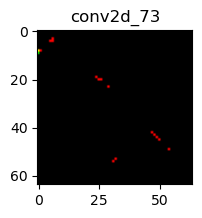

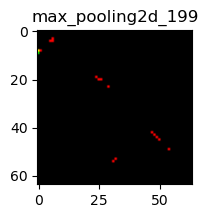

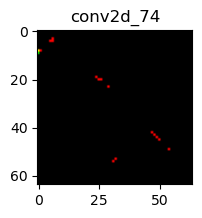

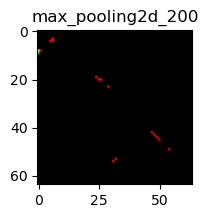

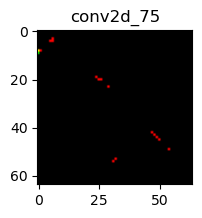

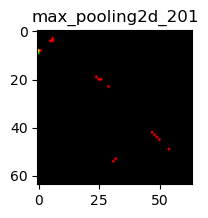

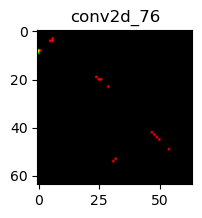

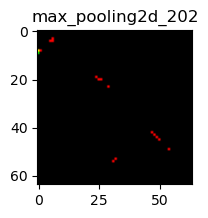

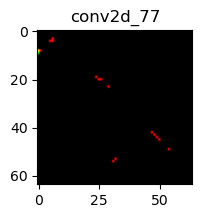

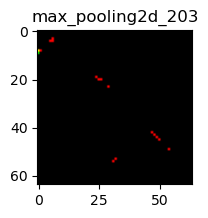

In [550]:
printfeatMap(feature_maps3,layer_names3)

In [ ]:
### ResNet Model with trainable true

In [542]:
def create_resnet_model_2():
    input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
    x= data_augmentation(input_layer)
    base_model = tf.keras.applications.ResNet50V2(
                    include_top=False,
                    weights='imagenet',
                    input_tensor=x
                )
    
    base_model.trainable = True
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=metrics)
    return model
resnetmodel2= create_resnet_model()

In [543]:
resnetmodel2.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_34 (Flatten)        (None, 8192)              0         
                                                                 
 dense_75 (Dense)            (None, 1)                 8193      
                                                                 
Total params: 23,572,993
Trainable params: 8,193
Non-trainable params: 23,564,800
_________________________________________________________________


In [545]:
resnet2_history = resnetmodel2.fit(train_ds,
          steps_per_epoch=600,
          validation_data=   val_ds,
          validation_steps=600,
                           callbacks=[earlyStopCallback],
         
          epochs=epochs)

Epoch 1/2
600/600 [==============================] - 176s 294ms/step - loss: 0.0000e+00 - accuracy: 0.1110 - f1_score: 0.9395 - precision_score: 0.8876 - recall_score: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 0.1111 - val_f1_score: 0.9404 - val_precision_score: 0.8891 - val_recall_score: 1.0000
Epoch 2/2
600/600 [==============================] - 19s 31ms/step - loss: 0.0000e+00 - accuracy: 0.1121 - f1_score: 0.9462 - precision_score: 0.8996 - recall_score: 1.0000


In [ ]:
resnetmodel2.evaluate(test_ds)